# Investigation of a simplified model for Uruguay

In [1]:
import pypsa

import matplotlib.pyplot as plt
import pandas as pd

~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


## Read data

In [2]:
input_fls = {
    "load": "inputs/uy_load.csv",
    "hydro": "inputs/uy_hydro.csv", "hydro_2023": "inputs/uy_hydro_2023.csv",
    "wind": "inputs/uy_wind.csv", "wind_2023": "inputs/uy_wind_2023.csv"
}

In [3]:
def read_df(inpit_fl):
    data_df = pd.read_csv(inpit_fl)
    data_df["snapshot"] = pd.to_datetime(data_df["snapshot"])
    return data_df

In [4]:
load_df = read_df(input_fls["load"])

hydro_df = read_df(input_fls["hydro"])
wind_df = read_df(input_fls["wind"])

hydro_2023_df = read_df(input_fls["hydro_2023"])
wind_2023_df = read_df(input_fls["wind_2023"])

## Explore inputs

### Wind

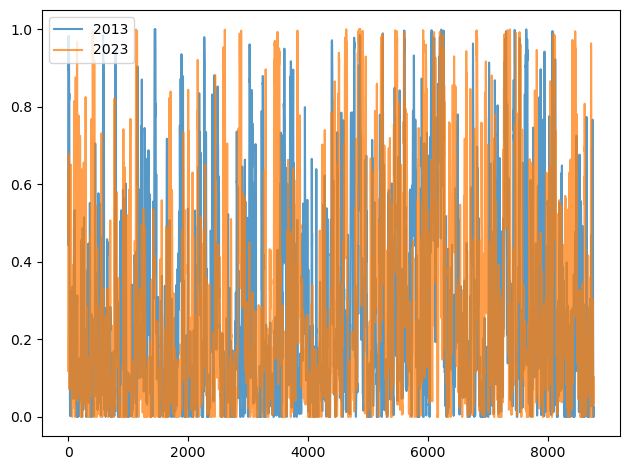

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
wind_df[["onwind"]].plot(ax=ax, alpha=0.75)
wind_2023_df[["onwind"]].plot(ax=ax, alpha=0.75)
plt.legend(["2013", "2023"], loc="best")
plt.tight_layout()

In [6]:
# wind potential, a share of the maximum
print(
    round(wind_df["onwind"].mean(), 2),
    round(wind_2023_df["onwind"].mean(), 2)
)

0.26 0.28


### Hydro

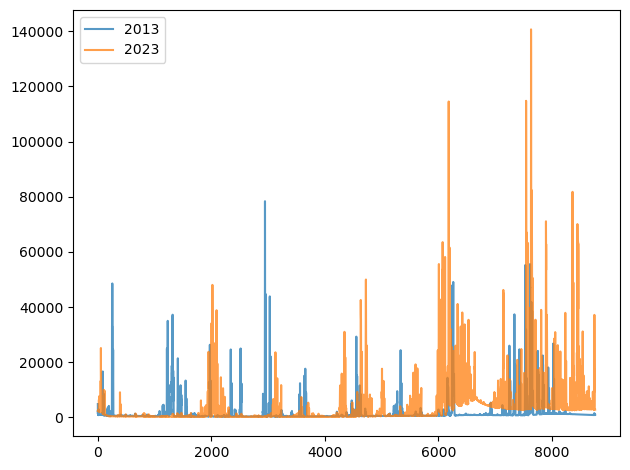

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
hydro_df["hydro"].plot(ax=ax, alpha=0.75)
hydro_2023_df["hydro"].plot(ax=ax, alpha=0.75)
plt.legend(["2013", "2023"], loc="best")
plt.tight_layout()

In [8]:
# hydro potential [MW]
print(
    round(hydro_df["hydro"].mean(), 2),
    round(hydro_2023_df["hydro"].mean(), 2)
)

1578.31 3764.93


In [9]:
# hydro potential [MW]
print(
    round(hydro_df["hydro"][0:2000].mean(), 2),
    round(hydro_2023_df["hydro"][0:2000].mean(), 2)
)

1509.83 700.39


## Build the model

In [10]:
def build_power_model(
        load_df,
        wind_ts,
        hydro_ts,
    ):
    network = pypsa.Network(snapshots = load_df.index)
    network.add("Bus", "B1")

    network.add("Generator", "Wind",
                carrier = "wind",
                bus="B1",
                capital_cost = 35_000,
                p_nom_max = 6_000,
                p_max_pu = wind_ts,
                p_nom_extendable = True,
                )

    # a fake generator which represents unserved energy 
    network.add("Generator", "LoadShedding",
                carrier = "shedding",
                bus="B1",
                capital_cost = 0,
                marginal_cost = 100_000,
                p_nom_extendable = True)

    network.add("StorageUnit", "Hydro",
                bus="B1",
                max_hours = 24 * 14,
                p_max_pu=1.0,  # dispatch
                p_min_pu=0.0,  # store
                p_nom = 2_000,
                inflow = hydro_ts,       
                p_nom_extendable = False,
                efficiency_dispatch=0.9,
                efficiency_store=0.0,
                cyclic_state_of_charge=True)

    network.add("Load", "L1",
                bus="B1",
                p_set=load_df["load"])
    return network

In [11]:
model_2013 = build_power_model(
    load_df=load_df,
    wind_ts=wind_df["onwind"],
    hydro_ts=hydro_df["hydro"]
)
model_2023 = build_power_model(
    load_df=load_df,
    wind_ts=wind_2023_df["onwind"],
    hydro_ts=hydro_2023_df["hydro"]
)

~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' 

### Optimisation runs

In [12]:
model_2013.lopf()

/var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/ipykernel_60723/3676816951.py:1: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  model_2013.lopf()
INFO:pypsa.linopf:Prepare linear problem
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/linopf.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat([bus_injection(*arg) for arg in args], axis=1)
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/linopf.py:538: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:pypsa.linopf:Total preparation time: 0.71s
INFO:pypsa.linopf:Solve linea

('ok', 'optimal')

In [13]:
model_2023.lopf()

/var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/ipykernel_60723/314619590.py:1: DeprecatedWarning: lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.
  model_2023.lopf()
INFO:pypsa.linopf:Prepare linear problem
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/linopf.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat([bus_injection(*arg) for arg in args], axis=1)
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/linopf.py:538: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:pypsa.linopf:Total preparation time: 0.71s
INFO:pypsa.linopf:Solve linear

('ok', 'optimal')

## Optimisation results

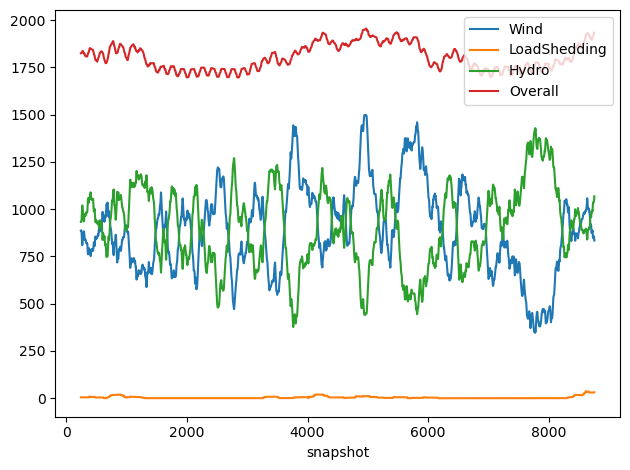

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
model_2013.generators_t.p[["Wind", "LoadShedding"]].rolling(240).mean().plot(ax=ax)
model_2013.storage_units_t.p.rolling(240).mean().plot(ax=ax)
model_2013.loads_t.p_set["L1"].rolling(240).mean().plot(ax=ax)

plt.legend(["Wind", "LoadShedding", "Hydro", "Overall", "Load"], loc="best")
plt.tight_layout()

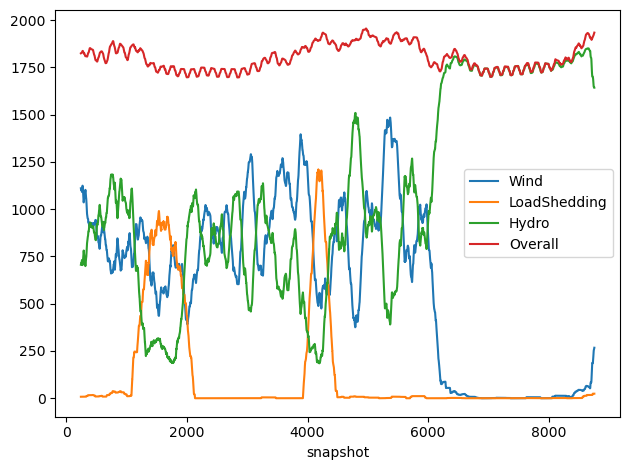

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
model_2023.generators_t.p[["Wind", "LoadShedding"]].rolling(240).mean().plot(ax=ax)
model_2023.storage_units_t.p.rolling(240).mean().plot(ax=ax)
model_2023.loads_t.p_set["L1"].rolling(240).mean().plot(ax=ax)

plt.legend(["Wind", "LoadShedding", "Hydro", "Overall", "Load"], loc="best")
plt.tight_layout()

In [16]:
print(
    round(model_2013.generators_t.p[["LoadShedding"]].sum().sum() / 1e6, 2),
    round(model_2023.generators_t.p[["LoadShedding"]].sum().sum() / 1e6, 2)
)

0.04 1.04
